In [1]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import model_from_json
from keras.utils import to_categorical
from sklearn.utils import class_weight

import time 
import sys
import os
from collections import Counter
import pickle as pkl
import pandas as pd
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def load_dataset(filename):
    dataset = pd.read_csv(filename,index_col = "TR_NO",usecols = ["TR_NO","TR_AMT","TR_BAL_AMT","FUND_USE","IS_CASH"])
    dataset = dataset.replace([np.inf, -np.inf], np.nan).fillna(value=0)
    return dataset

def get_negtive_trans(filename):
    return set(pd.read_csv(filename)["TR_NO"].values)

In [3]:
training_dataset_filename = "T3H_TRANS_ALL_WW_DATA_TABLE.csv"
case_filename = "T3H_TRANS_YSB_WW_DATA_TABLE.csv"

## ------- load dataset --------
if not os.path.exists("unsup_cases.pkl") or not os.path.exists("unsup_training_dataset.pkl"):
    training_dataset = load_dataset(training_dataset_filename)
    cases = get_negtive_trans(case_filename)

    with open("unsup_cases.pkl","wb") as f:
        pkl.dump(cases,f)
    with open("unsup_training_dataset.pkl","wb") as f:
        pkl.dump(training_dataset,f)
else:
    with open("unsup_cases.pkl","rb") as f:
        cases = pkl.load(f)
    with open("unsup_training_dataset.pkl","rb") as f:
        training_dataset = pkl.load(f)

## Feature engneering

In [4]:
encoder = LabelEncoder()
training_dataset["FUND_USE"] = encoder.fit_transform(training_dataset["FUND_USE"].astype(str))
training_dataset.head()

,IS_CASH,TR_AMT,TR_BAL_AMT,FUND_USE
TR_NO,,,,
0013840100000026,1,61260.0,111260.0,974
0013840100000027,1,110000.0,1260.0,783
0013840100000027,1,110000.0,110000.0,783
0013840100000028,0,10000.0,0.0,973
0013840100000029,0,12000.0,12000.0,737


## 查看每个TR_NO交易个数

In [5]:
print(training_dataset.groupby("TR_NO").size().head())
print("")
print(training_dataset.loc[cases].groupby("TR_NO").size().head())
print("")
print(training_dataset.loc[cases].groupby("TR_NO").size().describe())

TR_NO
00000000000020180814000300014016    1
00000000000020180814000300014021    1
00000000000020180814000300014026    1
00000000000020180814000300014032    1
00000000000020180814000300014038    1
dtype: int64

TR_NO
ED00010101000001    30
ED00010101000011    23
ED00010101000040    24
ED00010101000110    21
ED00010101000126    15
dtype: int64

count    4698.000000
mean       24.579821
std        10.213524
min         1.000000
25%        18.000000
50%        31.000000
75%        32.000000
max        55.000000
dtype: float64


## create NUM_TRANS

In [6]:
table = training_dataset.groupby("TR_NO").size().to_dict()
values = training_dataset.index.to_series().map(table)
training_dataset["NUM_TRANS"] = values

In [7]:
abnormal_transactions = training_dataset.loc[cases]

## IS_CASH

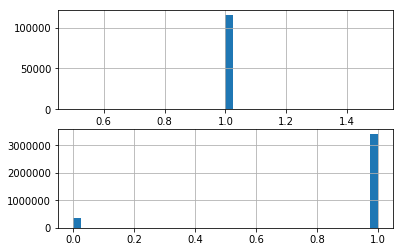

In [8]:
%matplotlib inline
plt.subplot(2, 1, 1)
abnormal_transactions["IS_CASH"].hist(bins = 40)
plt.subplot(2,1,2)
training_dataset["IS_CASH"].hist(bins = 40)

## FUND_USE

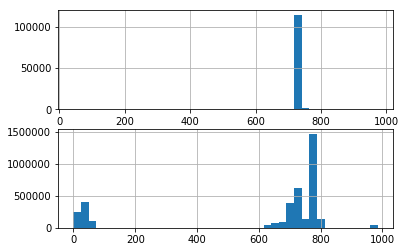

In [9]:
%matplotlib inline
plt.subplot(2, 1, 1)
abnormal_transactions["FUND_USE"].hist(bins = 40)
plt.subplot(2,1,2)
training_dataset["FUND_USE"].hist(bins = 40)

## NUM_TRANS

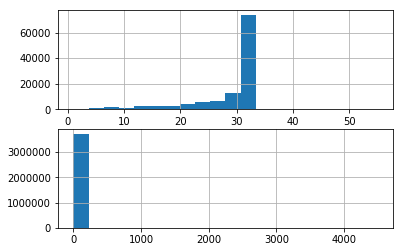

In [10]:
%matplotlib inline
plt.subplot(2, 1, 1)
abnormal_transactions["NUM_TRANS"].hist(bins = 20)
plt.subplot(2,1,2)
training_dataset["NUM_TRANS"].hist(bins = 20)

In [11]:
print(training_dataset.shape)
print(abnormal_transactions.shape)
print(training_dataset.head(20))
print(abnormal_transactions.head(20))

(3764326, 5)
(115476, 5)
                  IS_CASH    TR_AMT  TR_BAL_AMT  FUND_USE  NUM_TRANS
TR_NO                                                               
0013840100000026        1   61260.0   111260.00       974         22
0013840100000027        1  110000.0     1260.00       783         26
0013840100000027        1  110000.0   110000.00       783         26
0013840100000028        0   10000.0        0.00       973         22
0013840100000029        0   12000.0    12000.00       737         27
0013840100000057        0     570.0    39939.78       673          1
0013840100000058        0    4000.0    10031.05       673          1
0013840100000059        0   10000.0    10000.00       737          1
0013840100000061        1   27000.0    13183.69       721          1
0013840100000062        1   12000.0     1183.69       721          1
0013840100000064        1      10.0     1163.69       692          1
0014790100000001        0   40000.0    40000.00       737         25
001479010

In [12]:
def creat_labels(training_dataset,cases):
    training_dataset["Y"] = 1
    training_dataset.loc[training_dataset.index.isin(cases),"Y"] = 0
    labels = training_dataset["Y"].values
    training_dataset.drop(labels = "Y",axis = 1,inplace = True)
    return labels
labels = creat_labels(training_dataset,cases)    

In [13]:
print("samples distribution: {}".format(Counter(labels)))

samples distribution: Counter({1: 3648850, 0: 115476})


## Nomalization

In [14]:
scaler = StandardScaler()
training_dataset = scaler.fit_transform(training_dataset)
training_dataset[0:10]

/Users/ZRC/miniconda3/envs/bank/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ZRC/miniconda3/envs/bank/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 0.31827256,  0.00667837, -0.11557997,  1.26782744, -0.12897192],
       [ 0.31827256,  0.02824937, -0.12438605,  0.60249652, -0.11020922],
       [ 0.31827256,  0.02824937, -0.11568084,  0.60249652, -0.11020922],
       [-3.14196108, -0.01600791, -0.12448692,  1.26434404, -0.12897192],
       [-3.14196108, -0.01512276, -0.12352626,  0.44225975, -0.10551855],
       [-3.14196108, -0.02018137, -0.12128953,  0.21932164, -0.22747605],
       [-3.14196108, -0.01866334, -0.12368388,  0.21932164, -0.22747605],
       [-3.14196108, -0.01600791, -0.12368637,  0.44225975, -0.22747605],
       [ 0.31827256, -0.00848417, -0.1234315 ,  0.38652522, -0.22747605],
       [ 0.31827256, -0.01512276, -0.12439216,  0.38652522, -0.22747605]])

In [15]:
#min_max_scaler = StandardScaler()
#training_dataset = min_max_scaler.fit_transform(training_dataset)
prediction_time = 1 
testdatasize = 100000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = training_dataset[0:-prediction_time-testdatacut]
y_train = labels[prediction_time:-testdatacut]

# test data
x_test = training_dataset[0-testdatacut:-prediction_time]
y_test = labels[prediction_time-testdatacut:]

In [16]:
# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (3664274, 5)
y_train (3664274,)
x_test (100050, 5)
y_test (100050,)


In [17]:
def unroll(data,sequence_length=50): 
    result = []
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length])
    return np.asarray(result)
    
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]
# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (3664224, 50, 5)
y_train (3664224,)
x_test (100000, 50, 5)
y_test (100000,)


In [18]:
print("distribution of y_test: {}".format(Counter(y_test)))

distribution of y_test: Counter({1: 97972, 0: 2028})


In [19]:
model = Sequential()

model.add(LSTM(input_shape=(None, 5),
               units=50, dropout = 0.2,
               return_sequences=True)
         )
model.add(LSTM(100,dropout= 0.2,return_sequences=False))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [20]:
model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=1,
    class_weight = {1:1.0,0:3.0},
    validation_split=0.1)

Train on 3297801 samples, validate on 366423 samples
Epoch 1/1
3297801/3297801 [==============================] - 1880s 570us/step - loss: 0.2007 - val_loss: 0.2143


In [21]:
p = model.predict(x_test)

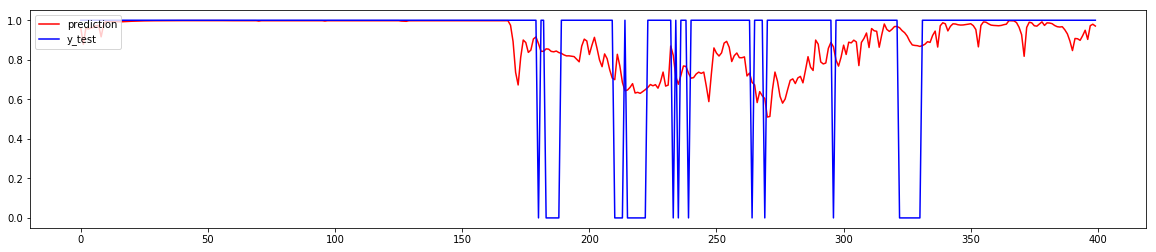

In [23]:
plt.figure(figsize = (20,4))
plt.plot(p[0:400],color='red', label='prediction')
plt.plot(y_test[0:400],color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [27]:
print("test data evaluate: ", model.evaluate(x_test, y_test))

 13344/100000 [===>..........................] - ETA: 37s

KeyboardInterrupt: 

In [31]:
threhold = 0.9
pred_labels = [0 if label < threhold else 1 for label in a]
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.03      0.93      0.06      2028
           1       1.00      0.44      0.61     97972

   micro avg       0.45      0.45      0.45    100000
   macro avg       0.52      0.69      0.34    100000
weighted avg       0.98      0.45      0.60    100000

